In [2]:
import graphlab
import matplotlib.pyplot as plt
%matplotlib inline
graphlab.canvas.set_target('ipynb', port=None)
sales = graphlab.SFrame('kc_house_data.gl/')
train_data,test_data = sales.random_split(.8,seed=0)

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1515530009.log


This non-commercial license of GraphLab Create for academic use is assigned to khewitt08@live.com and will expire on December 28, 2018.


In [3]:
def simple_linear_regression(input_feature, output):
    # compute the sum of input_feature and output
    feature_sum = input_feature.sum()
    output_sum = output.sum()
    num_inputs = output.size()
    
    # compute the product of the output and the input_feature and its sum
    product_sum = (input_feature *output).sum()
    
    # compute the squared value of the input_feature and its sum
    squared_sum = (input_feature ** 2).sum()
    # use the formula for the slope
    numerator = product_sum - ((float(1)/num_inputs) * (feature_sum*output_sum))
    denominator = squared_sum - ((float(1)/num_inputs) * (feature_sum*feature_sum))
    slope = numerator/denominator
    # use the formula for the intercept
    intercept = output.mean() - slope * input_feature.mean()
    return (intercept, slope)

In [4]:
test_feature = graphlab.SArray(range(5))
test_output = graphlab.SArray(1 + 1*test_feature)
(test_intercept, test_slope) =  simple_linear_regression(
    test_feature, test_output)
print "Intercept: " + str(test_intercept)
print "Slope: " + str(test_slope)

Intercept: 1.0
Slope: 1.0


In [5]:
sqft_intercept, sqft_slope = simple_linear_regression(
    train_data['sqft_living'], train_data['price'])

print "Intercept: " + str(sqft_intercept)
print "Slope: " + str(sqft_slope)

Intercept: -47116.0765749
Slope: 281.958838568


In [6]:
def get_regression_predictions(input_feature, intercept, slope):
    # calculate the predicted values:
    return  slope*input_feature + intercept

In [7]:
my_house_sqft = 2650
estimated_price = get_regression_predictions(
    my_house_sqft, sqft_intercept, sqft_slope)
print "The estimated price for a house with %d squarefeet is $%.2f" % (
    my_house_sqft, estimated_price)

The estimated price for a house with 2650 squarefeet is $700074.85


In [8]:
def get_residual_sum_of_squares(input_feature, output, intercept, slope):
    # First get the predictions
    predicted_price = get_regression_predictions(input_feature, intercept,slope)
    # then compute the residuals (since we are squaring it doesn't matter which order you subtract)
    residual = output - (slope*input_feature+intercept)
    # square the residuals and add them up
    RSS = residual * residual
    return(RSS.sum())

In [9]:
print get_residual_sum_of_squares(
    test_feature, test_output, test_intercept, test_slope) 
# should be 0.0

0.0


In [10]:
rss_prices_on_sqft = get_residual_sum_of_squares(
    train_data['sqft_living'], train_data['price'], 
    sqft_intercept, sqft_slope)
print 'The RSS of predicting Prices based on Square Feet is : ' + str(
    rss_prices_on_sqft)

The RSS of predicting Prices based on Square Feet is : 1.20191835632e+15


In [11]:
def inverse_regression_predictions(output, intercept, slope):
    return  (output-intercept)/slope

In [12]:
my_house_price = 800000
estimated_squarefeet = inverse_regression_predictions(
    my_house_price, sqft_intercept, sqft_slope)
print "The estimated squarefeet for a house worth $%.2f is %d" % (
    my_house_price, estimated_squarefeet)

The estimated squarefeet for a house worth $800000.00 is 3004


In [13]:
bedrooms_intercept, bedrooms_slope = simple_linear_regression(
    train_data['bedrooms'], train_data['price'])

print "Intercept: " + str(bedrooms_intercept)
print "Slope: " + str(bedrooms_slope)

Intercept: 109473.180469
Slope: 127588.952175


In [14]:
# Compute RSS when using bedrooms on TEST data:
rss_prices_on_bedrooms_test = get_residual_sum_of_squares(
    test_data['bedrooms'], test_data['price'],
    bedrooms_intercept, bedrooms_slope)
print 'The RSS of predicting Prices based on Bedrooms is : ' + str(
    rss_prices_on_bedrooms_test)

The RSS of predicting Prices based on Bedrooms is : 4.93364582868e+14


In [15]:
# Compute RSS when using squarfeet on TEST data:
rss_prices_on_sqft_test = get_residual_sum_of_squares(
    test_data['sqft_living'], test_data['price'], 
    sqft_intercept, sqft_slope)
print 'The RSS of predicting Prices based on Square Feet is : ' + str(
    rss_prices_on_sqft_test)

The RSS of predicting Prices based on Square Feet is : 2.75402936247e+14


In [16]:
example_features = ['sqft_living', 'bedrooms', 'bathrooms']
example_model = graphlab.linear_regression.create(
    train_data, target = 'price', features = example_features, 
                                                  validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 17384

Number of features          : 3

Number of unpacked features : 3

Number of coefficients    : 4

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 1.049275     | 4146407.600631     | 258679.804477 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [17]:
example_weight_summary = example_model.get("coefficients")
print example_weight_summary
example_predictions = example_model.predict(train_data)
print example_predictions[0] # should be 271789.505878

+-------------+-------+----------------+---------------+
|     name    | index |     value      |     stderr    |
+-------------+-------+----------------+---------------+
| (intercept) |  None | 87910.0724924  |  7873.3381434 |
| sqft_living |  None | 315.403440552  | 3.45570032585 |
|   bedrooms  |  None | -65080.2155528 | 2717.45685442 |
|  bathrooms  |  None | 6944.02019265  | 3923.11493144 |
+-------------+-------+----------------+---------------+
[4 rows x 4 columns]

271789.505878


In [18]:
def get_residual_sum_of_squares(model, data, outcome):
    # First get the predictions
    predictions = model.predict(data)
    # Then compute the residuals/errors
    errors = outcome - predictions
    # Then square and add them up
    RSS = (errors ** 2).sum()
    return(RSS) 

In [19]:
rss_example_train = get_residual_sum_of_squares(example_model, test_data, test_data['price'])
print rss_example_train # should be 2.7376153833e+14

2.7376153833e+14


In [20]:
from math import log
train_data['bedrooms_squared'] = train_data['bedrooms'].apply(lambda x: x**2)
train_data['bed_bath_rooms'] = train_data['bedrooms'] * train_data['bathrooms']
train_data['log_sqft_living'] = train_data['sqft_living'].apply(lambda x: log(x))
train_data['lat_plus_long'] = train_data['lat'] + train_data['long']

test_data['bedrooms_squared'] = test_data['bedrooms'].apply(lambda x: x**2)
test_data['bed_bath_rooms'] = test_data['bedrooms'] * test_data['bathrooms']
test_data['log_sqft_living'] = test_data['sqft_living'].apply(lambda x: log(x))
test_data['lat_plus_long'] = test_data['lat'] + test_data['long']

In [21]:
model_1_features = ['sqft_living', 'bedrooms', 'bathrooms', 'lat', 'long']
model_2_features = model_1_features + ['bed_bath_rooms']
model_3_features = model_2_features + ['bedrooms_squared', 'log_sqft_living', 'lat_plus_long']

In [22]:
model_1 = graphlab.linear_regression.create(train_data, target = 'price', 
                                            features = model_1_features, validation_set = None)
model_2 = graphlab.linear_regression.create(train_data, target = 'price', 
                                            features = model_2_features, validation_set = None)
model_3 = graphlab.linear_regression.create(train_data, target = 'price', 
                                            features = model_3_features, validation_set = None)


Linear regression:

--------------------------------------------------------

Number of examples          : 17384

Number of features          : 5

Number of unpacked features : 5

Number of coefficients    : 6

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.100621     | 4074878.213096     | 236378.596455 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 17384

Number of features          : 6

Number of unpacked features : 6

Number of coefficients    : 7

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.128063     | 4014170.932927     | 235190.935428 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

Linear regression:

--------------------------------------------------------

Number of examples          : 17384

Number of features          : 9

Number of unpacked features : 9

Number of coefficients    : 10

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.091382     | 3193229.177894     | 228200.043155 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [23]:
# Examine/extract each model's coefficients:
print model_1.get("coefficients")
print model_2.get("coefficients")
print model_3.get("coefficients")

+-------------+-------+----------------+---------------+
|     name    | index |     value      |     stderr    |
+-------------+-------+----------------+---------------+
| (intercept) |  None | -56140675.7444 | 1649985.42028 |
| sqft_living |  None | 310.263325778  | 3.18882960408 |
|   bedrooms  |  None | -59577.1160682 | 2487.27977322 |
|  bathrooms  |  None | 13811.8405418  | 3593.54213297 |
|     lat     |  None | 629865.789485  | 13120.7100323 |
|     long    |  None | -214790.285186 | 13284.2851607 |
+-------------+-------+----------------+---------------+
[6 rows x 4 columns]

+----------------+-------+----------------+---------------+
|      name      | index |     value      |     stderr    |
+----------------+-------+----------------+---------------+
|  (intercept)   |  None | -54410676.1152 | 1650405.16541 |
|  sqft_living   |  None | 304.449298057  | 3.20217535637 |
|    bedrooms    |  None | -116366.043231 | 4805.54966546 |
|   bathrooms    |  None | -77972.3305135 | 7565

In [24]:
# Compute the RSS on TRAINING data for each of the three models and record the values:
RSS_1 = get_residual_sum_of_squares(model_1, train_data, train_data['price'])
RSS_2 = get_residual_sum_of_squares(model_2, train_data, train_data['price'])
RSS_3 = get_residual_sum_of_squares(model_3, train_data, train_data['price'])

print RSS_1
print RSS_2
print RSS_3

9.71328233544e+14
9.61592067856e+14
9.05276314555e+14


In [25]:
# Compute the RSS on TESTING data for each of the three models and record the values:
RSS_1 = get_residual_sum_of_squares(model_1, test_data, test_data['price'])
RSS_2 = get_residual_sum_of_squares(model_2, test_data, test_data['price'])
RSS_3 = get_residual_sum_of_squares(model_3, test_data, test_data['price'])

print RSS_1
print RSS_2
print RSS_3

2.26568089093e+14
2.24368799994e+14
2.51829318952e+14


In [28]:
import numpy as np

def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

def predict_output(feature_matrix, weights):
    return np.dot(feature_matrix, weights)

(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price')

my_weights = np.array([1., 1.]) # the example weights
my_features = example_features[0,] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print 'predicted value ' + str(predicted_value)

test_predictions = predict_output(example_features, my_weights)
print test_predictions[0] # should be 1181.0
print test_predictions[1] # should be 2571.0

predicted value 1181.0
1181.0
2571.0


In [29]:
def feature_derivative(errors, feature):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    derivative = 2 * np.dot(errors, feature)
    return(derivative)

In [30]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
# just like SFrames 2 numpy arrays can be elementwise subtracted with '-': 
errors = test_predictions - example_output # prediction errors in this case is just the -example_output
feature = example_features[:,0] # let's compute the derivative with respect to 'constant', the ":" indicates "all rows"
derivative = feature_derivative(errors, feature)
print derivative
print -np.sum(example_output)*2 # should be the same as derivative

-23345850022.0
-23345850022.0


In [31]:
from math import sqrt 
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    weights = np.array(initial_weights) # make sure it's a numpy array
    while not converged:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        gradient_sum_squares = 0 # initialize the gradient sum of squares
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(errors, feature_matrix[:,i])
            # add the squared value of the derivative to the gradient magnitude (for assessing convergence)
            gradient_sum_squares = gradient_sum_squares + (derivative * derivative)
            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        # compute the square-root of the gradient sum of squares to get the gradient matnigude:
        gradient_magnitude = sqrt(gradient_sum_squares)
        if gradient_magnitude < tolerance:
            converged = True
    return(weights)

In [32]:
# let's test out the gradient descent
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7

simple_weights = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance)
print simple_weights
print round(simple_weights[1], 1)

[-46999.88716555    281.91211912]
281.9


In [34]:
(test_simple_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)
simple_predictions = predict_output(test_simple_feature_matrix, simple_weights) #compute predictions
print round(simple_predictions[0]) #nearest dollar prediction of the first house in the dataset

356134.0


In [35]:
model_features = ['sqft_living', 'sqft_living15'] 
# sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
initial_weights = np.array([-100000., 1., 1.])
step_size = 4e-12
tolerance = 1e9

multiple_weights = regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance)
print multiple_weights

[ -9.99999688e+04   2.45072603e+02   6.52795277e+01]


In [36]:
(test_multiple_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)
multiple_predictions = predict_output(test_multiple_feature_matrix, multiple_weights)
print round(multiple_predictions[0])

366651.0


In [37]:
test_data['price'][0]

310000.0

In [40]:
multiple_test_errors = multiple_predictions - test_output
RSSm = sum(multiple_test_errors * multiple_test_errors)

test_errors = simple_predictions - test_output
RSSs = sum(test_errors * test_errors)

print str(RSSm)+'(RSSm) > ' + str(RSSs) + '(RSSs)'
print RSSm > RSSs

2.70263446465e+14
2.75400047593e+14
2.70263446465e+14(RSSm) > 2.75400047593e+14(RSSs)
False


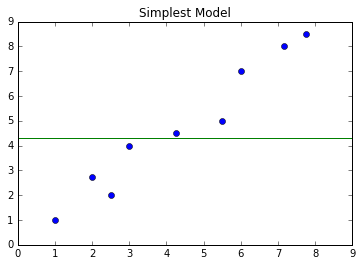

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Simplest Model')
plt.ylim(0,9)
plt.xlim(0,9)
line = list()
for i in range(10):
    line.append(4.3)

x = np.array([1, 2, 2.5, 3, 4.25, 5.5, 6, 7.15, 7.75])
y = np.array([1, 2.75, 2, 4, 4.5, 5, 7, 8, 8.5])

plt.plot(x,y,'o',line, '-')

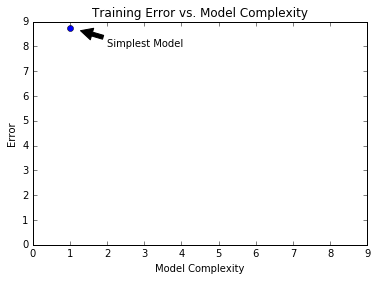

In [85]:
plt1 = plt
plt1.xlim(0,9)
plt1.ylim(0,9)
plt1.title("Training Error vs. Model Complexity")
plt1.xlabel('Model Complexity')
plt1.ylabel("Error")
simplest_model_x = 1
simplest_model_y = 8.75
plt1.annotate('Simplest Model', xy=(1.25, 8.65), xytext=(2, 8),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt1.plot(simplest_model_x, simplest_model_y, 'o')

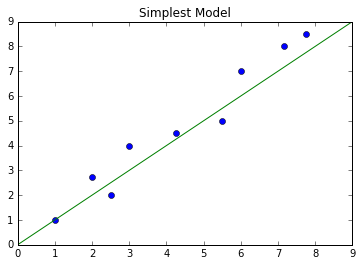

In [87]:
plt.title('Linear Model')
plt.ylim(0,9)
plt.xlim(0,9)
line = list()
for i in range(10):
    line.append(i)

x = np.array([1, 2, 2.5, 3, 4.25, 5.5, 6, 7.15, 7.75])
y = np.array([1, 2.75, 2, 4, 4.5, 5, 7, 8, 8.5])

plt.plot(x,y,'o',line, '-')

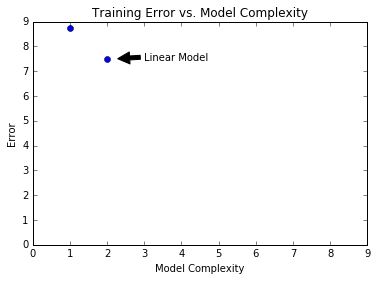

In [96]:
plt.xlim(0,9)
plt.ylim(0,9)
plt.title("Training Error vs. Model Complexity")
plt.xlabel('Model Complexity')
plt.ylabel("Error")
x = np.array([1, 2])
y = np.array([8.75, 7.5])
plt.annotate('Linear Model', xy=(2.25, 7.5), xytext=(3, 7.45),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot(x, y, 'o')

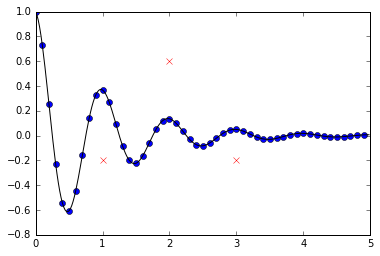

In [107]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(0.0, 5.0, 0.1)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k', [1,2,3],[-0.2, 0.6, -0.2], 'rx')

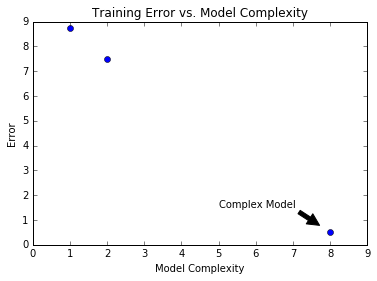

In [115]:
plt.xlim(0,9)
plt.ylim(0,9)
plt.title("Training Error vs. Model Complexity")
plt.xlabel('Model Complexity')
plt.ylabel("Error")
x = np.array([1, 2, 8])
y = np.array([8.75, 7.5, 0.5])
plt.annotate('Complex Model', xy=(7.75, .75), xytext=(5
                                                 , 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot(x, y, 'o')